# GAN (Generative Adversarial Network)
## Генеративно-состязательная нейросеть

#### Генеративно-состязательная сеть (англ. Generative adversarial network)
— алгоритм машинного обучения без учителя, построенный на комбинации из двух нейронных сетей, одна из которых (сеть $G$, генератор) генерирует образцы，а другая (сеть $D$, дискриминатор) старается отличить правильные («подлинные») образцы от неправильных. https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C

Если совсем коротко, то:

$$\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]$$

Где:
* $x$ - реальные данные из обучающй выборки
* $D(x)$ - результат работы дискриминатора, т.е. вероятность того, что перед нами несгенерированные данные
* $z$ - случайный вектор фиксированной длины, выбранный из нормального распределения
* $G(z)$ - сгенерированные из $z$ данные

Задача для $G$ - генерировать данные $p_g$ с таким же распределением как и у реальных данных  $p_{data}$ .
Цель $D$ же - отличать сгенерированные данные от оригиналов.
Тогда $D(G(z))$ - вероятность того, что данные из генератора являются реальными. Идеальный результат обучения GAN - $p_{data} = p_g$

### Генератор ($G$)

Задача генератора - создавать из ничего «поддельные» изображения заданного типа, похожие на те, что в обучающей выборке. Постепенно генератор делает это всё качественнее и качественнее.

После завершения обучения модель генератора используется для того, чтобы как раз и создавать новые изображения.



### Дискриминатор ($D$)

Модель дискриминатора берет входные данные (реальные или сгенерированный) и предсказывает к какому из этих двух классов принадлежат эти данные.
Обучение сводится к минимизация функции потерь.

После процесса обучения модель дискриминатора отбрасывается, поскольку нас уже интересует только генерация данных.

### Состязание

Генератор постоянно состязается с дискриминатором и пытается его обмануть. То есть обучение генератора и дискриниматора идёт совместно. \\

В итоге должно получится так, что генератор имеет почти нулевое значение функции потерь, а дискриминатор ошибается всегда и при любом раскладе, а значит его функция потерь максимально возможна.

### Vanilla GAN

Сделаем реализацю самой первой статьи по GAN'ам на классическом датасете MNIST

Generative Adversarial Nets Ian J. Goodfellow (2014) https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf  

Подключаем нужные модули и библиотеки

In [ ]:
import os
import numpy as np
import math

########### Ключевые библиотеки для работы самой нейронной сети ################################
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets # тут хранятся готовые наборы данных
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [ ]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Параметры для обучения обеих моделей

In [ ]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100 # это начальный размер генерируемых данных

n_classes = 10 # число классов на выходе
img_size = 28 # размер изображения - все изображения в MNIST 28 x 28
channels = 1 # изображение в оттенках серого

sample_interval = 25

img_shape = (channels, img_size, img_size) # итоговый размер 1 x 28 x 28

Генератор

Это стандратный ход - создание собственного класса для нейронной сети на базе nn.Module.

Для создания нужно минимум два метода: \\
1) __init__ - инициаализация структуры нашей сети   
2) forward - метод, который "прогоняет" входные данные чере нейронную сеть

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Использование таких словарей позволяет нам варьировать параметры нашей сети - в данном случае выбор функции активации
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])

        # по сути в этом блоке мы задаём параметры простого линейного слоя
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu или 'lrelu' или ...
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их с помощью списка.
            if normalize: #если хотим нормализацию, то тут она будет создана
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        # изначально мы берём данные в виде 100 цифр, затем они проходят через нейронную сеть и получается столько цифр, сколько нам нужно для картинки - 28*28
        img = self.model(z)
        # затем мы приобразуем эти цифры в матрицу, которую будем считать изображением
        img = img.view(img.size(0), *img_shape)
        return img


Вам так же может встретится создание собственных слоёв в нейронной сети. Это действие ничем не отличается от создания собственной нейронной сети.

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя - тогда их автоматически можно будет учить с помощью методов Torch

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) # это генерация нормально распределённых слчайных весов
        nn.init.uniform_(self.bias, -0.005, 0.005)

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

Дискриминатор:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512), # используем свои слои, созданные раньше
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )


    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

Загрузка датасета

In [ ]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 94662797.29it/s]


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32810317.94it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24188627.38it/s]


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17070366.28it/s]


Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



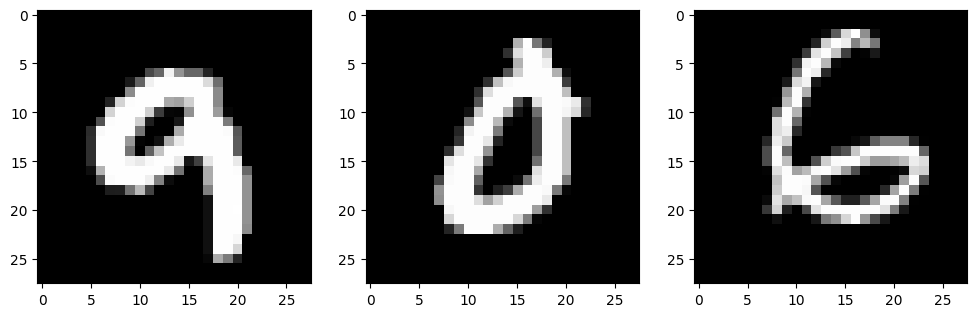

In [ ]:
dataiter = iter(real_data)
images, labels = next(dataiter)
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

Вот такие цифры мы должны в итоге получать. Размер цифры - 28 х 28.

Инициализация

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

[Epoch 133/200] [Batch 871/938] [D loss: 0.187713] [G loss: 2.833582]


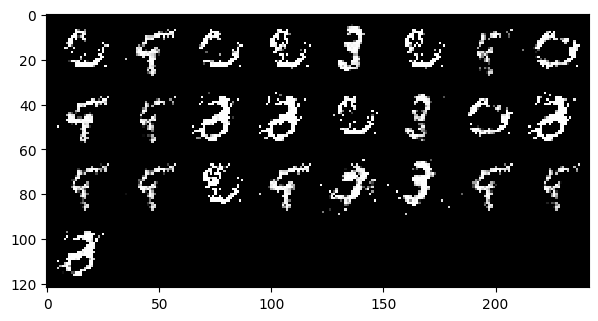

In [ ]:
for epoch in range(n_epochs):

    # наша задача: сгенерировать столько же искусственных данных, сколько и было настоящих, потому цикл проходит по реальным данным
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0] # там, где мы скачивали данные, мы разбивали их по батчам

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()

        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)

        # Подаем сгенерированые данные на Дискриминатор
        validity = discriminator(gen_imgs)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)

        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) )


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

Анимация первых 88 эпох обучения

In [ ]:
torch.save(generator.state_dict(), "vanilla_gan.pth")